# Молекулярная динамика

## Молекулярная механика

Основная идея молекулярной механики: любую молекулярную систему можно предствить в виде набора классических взаимодействующих частиц (атомов). Задача моделирования сводится к решению задачи N тел.

<img src="img/myoglobin_licorice2.png"  width="400">

## Силовое поле

Потенциальная функция (силовое поле) молекулярной динамики:

$$
V = V_{bonded} + V_{nb}
$$

Валентные взаимодействия (количество слагаемых ~ количество атомов):

$$
\begin{split}
V_{bonded} = &\sum_{(i,j)\in bonds}\frac{k^s_{ij}}{2}(r_{ij}-r_{ij}^0)^2 + \\
             &\sum_{(i,j,k)\in angles}\frac{k^{\theta}_{ijk}}{2}(\theta_{ijk}-\theta_{ijk}^0)^2 + \\
             &\sum_{(i,j,k,l)\in dihedrals}k^{\phi}_{ijkl}(1-\cos(n\phi_{ijkl} - \phi_{ijkl}^0)) + \\
             &\sum_{(i,j,k,l)\in impropers}k^{\psi}_{ijkl}(\psi_{ijkl}-\psi_{ijkl}^0)^2
\end{split}
$$

Невалентные взаимодействия (каждый с каждым):

$$
V_{nb} = \sum_{i,j}\varepsilon_{ij}\left[\left(\frac{\sigma_{ij}}{r_{ij}}\right)^{12}-2\left(\frac{\sigma_{ij}}{r_{ij}}\right)^{6}\right]
$$

## Молекулярная динамика

Молекулярная динамика развивает идею молекулярной механики следующим образом. Если есть возмоность посчитать энергию системы, то есть возможность посчитать и силы межатомного взаимодействия. Эти силы затем можно подставить в уравнения движения, получив таким образом динамику движения атомов системы.

Уравнения движения:

$$
\begin{split}
m_i\frac{d\mathbf{V}_{i}}{dt} &= \mathbf{f}_{i}\\
\frac{d\mathbf{r}_i}{dt} &= \mathbf{v}_{i}
\end{split}
$$

, где:

$$
\mathbf{f}_i = \nabla_i V = \begin{bmatrix}\frac{\partial}{\partial x_i}\\\frac{\partial}{\partial y_i}\\\frac{\partial}{\partial z_i}\end{bmatrix}V
$$

## Проблемма 1: Много атомов

Молекулярные системы обычно насчитывают огромное количество атомов. Например, куб воды нормальной плотности размеров 10х10х10 нм содержит примерно 10<sup>5</sup> атомов. Все атомы взаимодействую друг с другом, для каждого атома необходимо численно интегрировать уравнения движения. Это очень большое количество вычислений. Решается параллелизацией расчета: расчет сил можно производить одновременно.


## Проблемма 2: Маленький шаг численного интегрирования

Быстрые коллебания ковалентных связей диктуют необходимость использования очень маленького шага по времени ~1 фс (10<sup>-15</sup> с). Для достижения временных интервалов ~1 мс (10<sup>-3</sup> с) требуется огромное количество шагов численного интегрирования. Не решается параллелизацией: невозможно считать следующий шаг, не расчитав настоящий.


# Пакет GROMACS

## Проверка установки и подготовка к работе

In [ ]:
!gmx --version

Здесь, '!' означает, что выполнять комманду следует в коммандной строке. Кроме установленной версии программы GROMACS данная комманда должна распечатать информацию о том, как код был скомпилирован (под какую архитектуру, поддерживаются ли графические процессоры и т.д.).

Следующая ячейка создает отдельную директорию и переходит в нее. Обратите внимание, что перед командой 'cd' стоит знак '%', а не '!' для того, чтобы остаться в новой папке далее, при выполнении последующих ячеек.

In [ ]:
!mkdir sim
%cd sim

## Постановка задачи

В качестве примера, мы рассмотрим поведение молекул 4-Циано-4'-пентилбифенила (4-Cyano-4'-pentylbiphenyl, сокр. 5CB) под действием внешнего электростатического поля. Молекула 5CB примечательна тем, что она может переходить в жидкокристаллическую фазу при температуре 22.5-35 градусов Цельсия. Далее мы подготовим систему к моделированию в пакете GROMACS, проведем моделирование в присутствии внешнего электростатического поля и посмотрим как это поле влияет на упорядоченность молекул. Молекула 5CB выглядит следующим образом: 

<img src="img/5CB-wiki.png"  width="400">
*By Roland Mattern2. - Roland1952, Public Domain, https://commons.wikimedia.org/w/index.php?curid=7965966*

## Начальные данные

Вернемся к записи функции потенциальной энергии (на примере ковалентных связей):

$$
V_{bond}=\sum_{\color{green}{(i,j)\in bonds}}\frac{\color{red}{k^s_{ij}}}{2}({\color{blue}{r_{ij}}}-\color{red}{r_{ij}^0})^2
$$

Здесь, цветами обозначены величины, необходимые для расчета потенциальной энергии и, как следствие, сил межатомного взаимодействия. Красным цветом обозначены параметры, которые определяются выбором силового поля. Зеленый цвет обозначает связанность системы, так называемую топологию молекулы (молекул). Синий цвет соответствует координатам атомов системы. Эту информацию нужно сообщить программе GROMACS.

<img src="img/gmx_workflow.png" width="800">

### Выбор силового поля

$$
V_{bond}=\sum_{(i,j)\in bonds}\frac{\color{red}{k^s_{ij}}}{2}(r_{ij}-\color{red}{r_{ij}^0})^2
$$

Для описания взаимодействий между атомами в молекулярной динамике используется силовое поле. Силовое поле представляет собой набор файлов, в которых перечисленны возможные типы атомов, то как они связаны между собой в ряде молекул, какие параметры ковалентных взаимодействий у этих связей, какие у атомов заряды и т.д. Выбор силового поля является очень важным этапом в молекулярном моделировании. Например, силовые поля разработанные для биологических молекул, зачастую работают корректно только в физиологическом диапазоне температур и давлений.

Здесь мы будем использовать модифицированное силовое поле TRaPPE-UA, которое изначально разрабатывалось с целью корректно описывать фазовые состояния молекул. Поле было адаптировано к использованию в пакете GROMACS, но не входит в его стандартную поставку. Для того, чтобы скачать силовое поле [здесь](https://github.com/zhmurov/trappeua/archive/refs/heads/master.zip):

In [ ]:
%%bash

wget https://github.com/zhmurov/trappeua/archive/refs/heads/master.zip
unzip master.zip
rm master.zip
mv trappeua-master/trappeua.ff .
rm -rf trappeua-master

Для того, чтобы GROMACS обнаружил поле и его можно было бы использовать, необходимо чтобы папка с расширением 'ff' находилась в рабочей директории. Поэтому, мы переместили данную папку после распаковки архива. Можно также получить силовое поле напрямую из репозитория:

In [ ]:
#%%bash
#
#git clone https://github.com/zhmurov/trappeua
#mv trappeua/trappeua.ff .
#rm -rf trappeua

Параметры ковалентных взаимодействий содержаться в файле trappeua.ff/ffbonded.itp :

In [ ]:
!head -n 40 trappeua.ff/ffbonded.itp

### Координаты системы

$$
V_{bond}=\sum_{(i,j)\in bonds}\frac{k^s_{ij}}{2}({\color{blue}{r_{ij}}}-r_{ij}^0)^2
$$

Данная версия силового поля уже содержит координаты для молекулы 5CB, которые находятся в папке 'trappeua.ff/liquidcrystals/', файл координат:

In [ ]:
!cat trappeua.ff/liquidcrystals/5CB.pdb

Можно также визуализировать структуру при помощи, например, программы VMD или nglview:

In [ ]:
import nglview as ng
view = ng.show_structure_file("trappeua.ff/liquidcrystals/5CB.pdb")
view

Система будет включать 100 молекул внутрии куба с 4х4х4 нм. Важно, чтобы молекулы находились близко друг к другу, но не пересекались - это приведет к очень больщой энергии. С такой задачей хорошо справляется, например программа Packmol. Компиляция программы:

In [ ]:
%%bash

git clone https://github.com/m3g/packmol.git
cd packmol
git checkout v20.3.5
./configure
make

Интерфейсом взаимодействия с программой Packmol являются конфигурационные файлы, которые выглядят следующим образом:

In [ ]:
!cat ../input/packmol.inp

В заголовке файла задается толерантность (в ангстреммах) - насколько близко можно распологать молекулы, а также формат и имя файла для сохранения результата. Далее перечисляются компоненты системы, их файлы координат, количество и в каком объеме их требуется размещать. В нашем случае всего один компонент, в количестве 100 молекул в кубической ячейке 40Х40Х40 ангстремм. Для запуска процесса упаковки, выполним комманду:

In [ ]:
!packmol/packmol < ../input/packmol.inp

Готовый файл координат можно скопировать из директории с референтными данными:

In [ ]:
#!cp ../data/cong.pdb .

В результате получаем координаты:

In [ ]:
!head -n 40 conf.pdb

Визуализация:

In [ ]:
import nglview as ng
view = ng.show_structure_file("conf.pdb")
view

<img src="img/5cbX100.png"  width="400">

### Топология системы:

$$
V_{bond}=\sum_{\color{green}{(i,j)\in bonds}}\frac{k^s_{ij}}{2}(r_{ij}-r_{ij}^0)^2
$$

Для данной молекулы в силовом поле имеется файл топологии:

In [ ]:
!cat trappeua.ff/liquidcrystals/5CB.itp

Для системы из 100 молекул, достаточно включить данный файл директивой include и указать количество молекул:

In [ ]:
!cp ../input/topol.top .
!cat topol.top

## Подготовка системы

<img src="img/gmx_workflow.png" width="800">

### Задание размера системы и минимизация энергии:

In [ ]:
!cat ../input/em.mdp

In [ ]:
!gmx editconf -f conf.pdb -o conf.gro -box 4 4 4
!gmx grompp -f ../input/em.mdp -c conf.gro -o em.tpr
!gmx mdrun -deffnm em -nt 1

In [ ]:
!printf "Potential\n0\n" | gmx energy -f em.edr -o potential.xvg -xvg none

In [ ]:
import pandas as pd
df = pd.read_csv('potential.xvg', sep='\s+', header=None, names=['step','energy'])
df.plot('step')

### Уравновешивание системы

Уравновешивание системы при постоянном объеме:

In [ ]:
!cat ../input/nvt.mdp

In [ ]:
!gmx grompp -f ../input/nvt.mdp -c em.gro -o nvt.tpr
!gmx mdrun -deffnm nvt -nt 1

Если нет возможности провесли расчет, можно скопировать референтные значения:

In [ ]:
#!cp data/nvt* .

In [ ]:
!echo "Temperature" | gmx energy -f nvt.edr -o temperature.xvg -xvg none

In [ ]:
!cat temperature.xvg
import pandas as pd
df = pd.read_csv('temperature.xvg', sep='\s+', header=None, names=['time','temperature'])
df.plot('time')

Уравновешивание системы при постоянном давлении:

In [ ]:
!cat ../input/npt.mdp

In [ ]:
!gmx grompp -f ../input/npt.mdp -c nvt.gro -o npt.tpr
!gmx mdrun -deffnm npt -nt 1

Либо скопировать референтные значения:

In [ ]:
!cp data/npt* .

In [ ]:
!echo "Potential" | gmx energy -f npt.edr -o epot.xvg -xvg none

In [ ]:
import pandas as pd
df = pd.read_csv('epot.xvg', sep='\s+', header=None, names=['time','Potential energy'])
df.plot('time')

## Моделирование

In [ ]:
!cat ../input/md_iso_E.mdp

In [ ]:
%%bash

ELECTRIC_FIELD=1.0
cp ../input/md_iso_E.mdp md_iso_${ELECTRIC_FIELD}.mdp
sed -i "s/ELECTRIC_FIELD/${ELECTRIC_FIELD}/g" md_iso_${ELECTRIC_FIELD}.mdp
cat md_iso_${ELECTRIC_FIELD}.mdp

In [ ]:
!gmx grompp -f md_iso_${ELECTRIC_FIELD}.mdp -c npt.gro -o md_iso_${ELECTRIC_FIELD}.tpr
#!gmx mdrun -deffnm md_iso_${ELECTRIC_FIELD} -nt 4

Следующая ячейка скопирует референтные данные для набора электрических полей в диапазоне от 0 до 50 В/нм:

In [ ]:
!cp ../data/md_iso_* .

In [ ]:
import nglview as ng
view = ng.show_structure_file("md_iso_1.0.gro")
view

# Немного анализа результатов

Для оценки взаимной ориентации молекул, мы будем использовать параметр порядка $P_2$, который вычисляется по формуле:

$$
S=\langle P_2(cos\chi)\rangle=\frac{3\langle cos^2\chi\rangle - 1}{2}
$$

Здесь, $\chi$ - угол между двумя молекулами 5CB. Код, который расчитывает параметр:

/home/zhmurov/.local/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


100.0 0.097902389814714
200.0 0.04532512223703311
300.0 0.03854249368216767
400.0 0.09421234251396571
500.0 0.1681306455205933
600.0 0.2824172428863083
700.0 0.3262500297775561
800.0 0.4339332378106251
900.0 0.47286070618975684
1000.0 0.44492459789899663
1100.0 0.4283009815277178
1200.0 0.45377654214867436
1300.0 0.530650643426642
1400.0 0.5616467436098938
1500.0 0.5456888125505122
1600.0 0.48654244101464084
1700.0 0.4372740081068316
1800.0 0.49790534007837683
1900.0 0.535387393161264
2000.0 0.5066109747307235
2100.0 0.4610983153776065
2200.0 0.4794127100061276
2300.0 0.4029621651581796
2400.0 0.556284085939112
2500.0 0.6030638027315112
2600.0 0.6119234401593827
2700.0 0.6242727424631485
2800.0 0.5366566609269672
2900.0 0.5400731075860341
3000.0 0.5339535963079565
3100.0 0.4971447488602364
3200.0 0.5198965606861619
3300.0 0.5211843865998842
3400.0 0.5576676703675107
3500.0 0.5692158397731639
3600.0 0.5572903139103731
3700.0 0.5772182605751395
3800.0 0.5696432019330828
3900.0 0.59170866

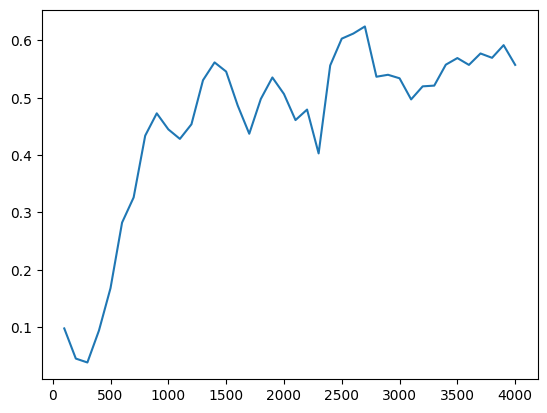

In [63]:
import MDAnalysis as mda

#electric_fields = ["0.00", "0.01", "0.1", "0.2", "0.5", "1.0", "10.0", "50.0"]
electric_fields = ["1.0"]

for electric_field in electric_fields:

    u = mda.Universe("conf.pdb", "md_iso_" + electric_field + ".xtc", in_memory="True")
    order_params = []
    times  = []
    file = open("order_parameter_" + electric_field + ".dat", "w")
    filter = u.trajectory[10::10]
    for ts in filter:
        box = ts.dimensions
        cosxi2 = 0.0
        ncosxi2 = 0
        ends1 = u.select_atoms("name N1")
        ends2 = u.select_atoms("name C19")
        for i in range(0, len(ends1) - 1):
            endi1 = ends1[i].position
            endi2 = ends2[i].position
            ri = endi2 - endi1
            ri[0] = ri[0] - round(ri[0] / box[0]) * box[0]
            ri[1] = ri[1] - round(ri[1] / box[1]) * box[1]
            ri[2] = ri[2] - round(ri[2] / box[2]) * box[2]
            ri_len = (ri[0]*ri[0] + ri[1]*ri[1] + ri[2]*ri[2]) ** 0.5
            for j in range(i + 1, len(ends1)):
                endj1 = ends1[j].position
                endj2 = ends2[j].position
                rj = endj2 - endj1
                rj[0] = rj[0] - round(rj[0] / box[0]) * box[0]
                rj[1] = rj[1] - round(rj[1] / box[1]) * box[1]
                rj[2] = rj[2] - round(rj[2] / box[2]) * box[2]
                rj_len = (rj[0]*rj[0] + rj[1]*rj[1] + rj[2]*rj[2]) ** 0.5
                cosxi = (ri[0]*rj[0] + ri[1]*rj[1] + ri[2]*rj[2]) / (ri_len * rj_len)
                cosxi2 += cosxi*cosxi
                ncosxi2 += 1
        cosxi2 /= ncosxi2
        order_param = (3.0*cosxi2 - 1.0)/2.0
        order_params.append(order_param)
        time = ts.time
        times.append(time)
        print(time, order_param)
        file.write(str(time) + " " + str(order_param) + "\n")
    
    import matplotlib.pyplot as plt
    fig = plt.figure()
    plt.plot(times, order_params)
    plt.show()
    fig.savefig("order_parameter_" + electric_field + ".png")